In [23]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Prepare data
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
root = "/tmp"
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 1000

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

for X_train, y_train in train_loader:
    break
for X_val, y_val in test_loader:
    break
    
if True:
    X_train = X_train.double()
    X_val = X_val.double()
    
if torch.cuda.is_available():
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

In [11]:
# Build model
from tda.models import pytorch_lenet
lenet = pytorch_lenet.LeNet()
lenet.train_or_load()
if torch.cuda.is_available():
    lenet = lenet.cuda()

Loaded LeNet_pretrained.pth


In [12]:
# Load or train model
lenet.train_or_load(train_loader=[(X_train, y_train)], val_data=(X_val, y_val),
                    num_epochs=50)

Loaded LeNet_pretrained.pth


In [13]:
# Build architecture (tda pipeline terminology)
import tda.models.architectures.parser as parser
from imp import reload
reload(parser)

x = X_train[0]
lenet_arch = parser.model_to_architecture(lenet, name="mnist_lenet",
                                          x=x)

2020-05-18 14:15:10,938 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7f7d61da26d0> received input with shape torch.Size([1, 1, 28, 28])
2020-05-18 14:15:10,940 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7f7d61da2790> received input with shape torch.Size([1, 20, 12, 12])


In [14]:
from tda.graph import Graph

graph = Graph.from_architecture_and_data_point(lenet_arch, x)
for key in graph._edge_dict:
    layer_matrix = graph._edge_dict[key]
    print(layer_matrix.shape)

(11520, 784)
(2880, 11520)
(3200, 2880)
(800, 3200)
(500, 800)
(10, 500)


In [26]:
# Compute thresholds
from tda.thresholds import process_thresholds

class Dataset(object):
    def __init__(self, name, X_train, y_train, X_test, y_test):
        self.name = name
        self.train_dataset = list(zip(X_train, y_train))
        self.test_and_val_dataset = list(zip(X_test, y_test))
        
    def __str__(self):
        return self.name
    
# %debug
threshold = 0.1
raw_thresholds = "_".join([str(threshold)] * len(lenet_arch.layers))
dataset = Dataset("mnist", X_train, y_train, X_val, y_val)
thresholds = process_thresholds(architecture=lenet_arch,
                                dataset=dataset,
                                raw_thresholds=raw_thresholds,
                                dataset_size=10)

2020-05-18 22:09:15,809 - Thresholds - INFO - Detected legacy format for thresholds
2020-05-18 22:09:15,810 - Thresholds - INFO - My received thresholds {(-1, 0): 0.1, (0, 1): 0.1, (1, 2): 0.1, (2, 3): 0.1, (3, 4): 0.1, (4, 5): 0.1}
2020-05-18 22:09:15,811 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_stats/architecture=mnist_lenet_e_0_dataset=mnist_dataset_size=10.cached for the call to get_stats
2020-05-18 22:09:15,961 - Thresholds - INFO - Link (-1, 0): threshold=8345.200295512639 (quantile 0.1)
2020-05-18 22:09:15,962 - Thresholds - INFO - Link (0, 1): threshold=53727.81221014217 (quantile 0.1)
2020-05-18 22:09:16,089 - Thresholds - INFO - Link (1, 2): threshold=495.33232805271695 (quantile 0.1)
2020-05-18 22:09:16,090 - Thresholds - INFO - Link (2, 3): threshold=26700.045048489563 (quantile 0.1)
2020-05-18 22:09:16,126 - Thresholds - INFO - Link (3, 4): threshold=190.12580075658255 (quantile 0.1)
2020-05-18 22:09:16,127 - Thresh

In [27]:
# Build tda dataset (i.e activation graphs for clean and adversarial inputs)
from tda.protocol import get_protocolar_datasets

# %debug
lims = X_train.min(), X_train.max()
dataset_size = 200
all_epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
(train_clean, test_clean, train_adv,
 test_adv) = get_protocolar_datasets(dataset=dataset,
                                     succ_adv=True,
                                     dataset_size=dataset_size,
                                     noise=0., compute_graph=False,
                                     all_epsilons=all_epsilons,
                                     attack_type="FGSM_art",
                                     archi=lenet_arch,
                                     lims=lims)

2020-05-18 22:09:24,749 - C3PO - INFO - I will produce for you the protocolar datasets !
2020-05-18 22:09:24,752 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=False_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=100_epsilon=0.0_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_offset=0_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset
2020-05-18 22:09:24,761 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=False_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=100_epsilon=0.0_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_offset=100_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset
2020-05-18 22:09:24,770 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robus

In [ ]:
import tda.graph

if False:
    print("\nComputing activation graphs for clean examples")
    for ds in train_clean, test_clean:
        for l, line in enumerate(ds):
            print(".", end="")
            if line.graph is None:
                ds[l] = line = line._replace(
                    graph=tda.graph.Graph.from_architecture_and_data_point(
                        lenet_arch, line.x))
        assert 0
print("\nComputing activation graphs for adversarial examples", end="")
for ds in train_adv, test_adv:
    for eps in ds:
        if eps != 0.2: continue
        print("\neps=%.3f" % eps)
        for l, line in enumerate(ds[eps]):
            print(".", end="")
            if line.graph is None:
                ds[eps][l] = line._replace(
                graph=tda.graph.Graph.from_architecture_and_data_point(
                lenet_arch, line.x))
    break

In [28]:
# Compute embeddings for test-set adversarial inputs
from tda.embeddings import get_embedding, EmbeddingType, KernelType, ThresholdStrategy
from joblib import delayed, Parallel


def embedding_getter(line):
    embedding = get_embedding(
        architecture=lenet_arch,
        embedding_type=EmbeddingType.PersistentDiagram,
        line=line, dataset=None, edges_to_keep=None,
        threshold_strategy=ThresholdStrategy.ActivationValue,
        thresholds=thresholds)
    print(".", end="")
    return embedding


n_jobs = 2
embeddings = {}
for eps in test_adv:
    print("\nComputing test adversarial embeddings for eps=%.3f" % eps)
    embeddings[eps] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_adv[eps])


Computing test adversarial embeddings for eps=0.010

Computing test adversarial embeddings for eps=0.050

Computing test adversarial embeddings for eps=0.100

Computing test adversarial embeddings for eps=0.200

Computing test adversarial embeddings for eps=0.300

Computing test adversarial embeddings for eps=0.400


In [29]:
embeddings[0] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_clean)

In [30]:
embeddings_test_adv = dict((eps, embeddings[eps]) for eps in embeddings if eps != 0)

In [31]:
# Compute other adversarial examples
embeddings_train_adv = {}
for eps in train_adv:
    print("\nComputing train adversarial embeddings for eps=%.3f" % eps)
    embeddings_train_adv[eps] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line) for line in train_adv[eps])
print("\nComputing train clean embeddings")
embeddings_train_clean = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in train_clean)
print("\nComputing test clean embeddings")
embeddings_test_clean = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_clean)


Computing train adversarial embeddings for eps=0.010

Computing train adversarial embeddings for eps=0.050

Computing train adversarial embeddings for eps=0.100

Computing train adversarial embeddings for eps=0.200

Computing train adversarial embeddings for eps=0.300

Computing train adversarial embeddings for eps=0.400

Computing train clean embeddings

Computing test clean embeddings


In [35]:
# The real deal: try to detect adversarial examples from normal examples
from tda.protocol import evaluate_embeddings

param_space = [{"M": 20, "sigma": sigma} for sigma in np.logspace(-3, 3, 7)]
kernel_type = KernelType.SlicedWasserstein
evaluation_results = evaluate_embeddings(embeddings_train_clean,
                                         embeddings_test_clean,
                                         embeddings_train_adv,
                                         embeddings_test_adv,
                                         kernel_type=kernel_type,
                                         param_space=param_space)

2020-05-18 23:00:10,670 - C3PO - INFO - I will evaluate your embeddings with SlicedWasserstein kernel !
2020-05-18 23:00:10,673 - C3PO - INFO - Found 100 clean embeddings for train
2020-05-18 23:00:10,673 - C3PO - INFO - Found 100 clean embeddings for test
2020-05-18 23:00:10,674 - Embeddings - INFO - Computing Gram matrix 100 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...
2020-05-18 23:00:10,674 - Embeddings - INFO - Using FWG !!!
2020-05-18 23:00:13,027 - Embeddings - INFO - Computed 100 x 100 gram matrix in 2.351829767227173 secs
2020-05-18 23:00:13,028 - C3PO - INFO - Computed all unsupervised Gram train matrices !
2020-05-18 23:00:13,028 - Embeddings - INFO - Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {

2020-05-18 23:00:31,389 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-18 23:00:31,390 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:00:31,391 - C3PO - INFO - Trained model in 0.0013432502746582031 secs
2020-05-18 23:00:31,466 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-18 23:00:31,466 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:00:31,469 - C3PO - INFO - Trained model in 0.0024929046630859375 secs
2020-05-18 23:00:31,560 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-18 23:00:31,561 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:00:31,562 - C3PO - INFO - Trained model in 0.0012753009796142578 secs
2020-05-18 23:00:31,666 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-18 23:00:31,667 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:00:31,669 - C3PO - INFO - Trained m

2020-05-18 23:00:34,667 - C3PO - INFO - Trained model in 0.0017108917236328125 secs
2020-05-18 23:00:34,762 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.6355999999999999
2020-05-18 23:00:34,762 - C3PO - INFO - sum gram matrix train = 100.00905166558356
2020-05-18 23:00:34,764 - C3PO - INFO - Trained model in 0.0018649101257324219 secs
2020-05-18 23:00:34,859 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.6355999999999999
2020-05-18 23:00:34,967 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7411000000000001
2020-05-18 23:00:34,967 - C3PO - INFO - sum gram matrix train = 234.89335834011732
2020-05-18 23:00:34,969 - C3PO - INFO - Trained model in 0.0016057491302490234 secs
2020-05-18 23:00:35,057 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.5606
2020-05-18 23:00:35,058 - C3PO - INFO - sum gram matrix train = 234.89335834011732
2020-05-18 23:00:35,059 - C3PO - INF

2020-05-18 23:00:57,413 - C3PO - INFO - Trained model in 0.0019516944885253906 secs
2020-05-18 23:00:57,567 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-18 23:00:57,568 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:00:57,571 - C3PO - INFO - Trained model in 0.0025322437286376953 secs
2020-05-18 23:00:57,732 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-18 23:00:57,732 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:00:57,733 - C3PO - INFO - Trained model in 0.0013082027435302734 secs
2020-05-18 23:00:57,895 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-18 23:00:57,896 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:00:57,898 - C3PO - INFO - Trained model in 0.002103567123413086 secs
2020-05-18 23:00:58,035 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-18 23:00:58,036 - C3PO 

2020-05-18 23:01:01,019 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:01,021 - C3PO - INFO - Trained model in 0.001539468765258789 secs
2020-05-18 23:01:01,095 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-18 23:01:01,096 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:01,098 - C3PO - INFO - Trained model in 0.001623392105102539 secs
2020-05-18 23:01:01,166 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-18 23:01:01,167 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:01,168 - C3PO - INFO - Trained model in 0.0015075206756591797 secs
2020-05-18 23:01:01,240 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-18 23:01:01,319 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5247
2020-05-18 23:01:01,319 - C3PO - INFO - sum gram matrix train = 100.00905166558356
2020-05-18 23:01:01,320 - C3P

2020-05-18 23:01:25,819 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-18 23:01:25,819 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:25,821 - C3PO - INFO - Trained model in 0.0018787384033203125 secs
2020-05-18 23:01:25,911 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-18 23:01:25,911 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:25,913 - C3PO - INFO - Trained model in 0.0012497901916503906 secs
2020-05-18 23:01:26,019 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-18 23:01:26,019 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:26,021 - C3PO - INFO - Trained model in 0.0015368461608886719 secs
2020-05-18 23:01:26,116 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-18 23:01:26,117 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:26,118 - C3PO - INFO - 

2020-05-18 23:01:28,819 - C3PO - INFO - Trained model in 0.001191854476928711 secs
2020-05-18 23:01:28,889 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-18 23:01:28,889 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:28,891 - C3PO - INFO - Trained model in 0.0013687610626220703 secs
2020-05-18 23:01:28,961 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-18 23:01:28,961 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:28,963 - C3PO - INFO - Trained model in 0.0013303756713867188 secs
2020-05-18 23:01:29,035 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-18 23:01:29,036 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:29,037 - C3PO - INFO - Trained model in 0.001607656478881836 secs
2020-05-18 23:01:29,122 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-18 23:01:29,122 - C3PO - INFO

2020-05-18 23:01:31,484 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.6795
2020-05-18 23:01:31,484 - C3PO - INFO - sum gram matrix train = 234.89335834011732
2020-05-18 23:01:31,485 - C3PO - INFO - Trained model in 0.0009510517120361328 secs
2020-05-18 23:01:31,558 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.6792
2020-05-18 23:01:31,558 - C3PO - INFO - sum gram matrix train = 234.89335834011732
2020-05-18 23:01:31,559 - C3PO - INFO - Trained model in 0.00092315673828125 secs
2020-05-18 23:01:31,634 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.6214
2020-05-18 23:01:31,712 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.7404999999999999
2020-05-18 23:01:31,712 - C3PO - INFO - Best param unsupervised {'M': 20, 'sigma': 100.0}
2020-05-18 23:01:31,713 - C3PO - INFO - Best nu param unsupervised 0.1
2020-05-18 23:01:31,713 - C3PO - INFO - Best param

2020-05-18 23:01:51,294 - C3PO - INFO - Trained model in 0.0013759136199951172 secs
2020-05-18 23:01:51,377 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-18 23:01:51,377 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:51,379 - C3PO - INFO - Trained model in 0.0015645027160644531 secs
2020-05-18 23:01:51,466 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-18 23:01:51,467 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:51,468 - C3PO - INFO - Trained model in 0.0013170242309570312 secs
2020-05-18 23:01:51,545 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-18 23:01:51,546 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:01:51,547 - C3PO - INFO - Trained model in 0.0013203620910644531 secs
2020-05-18 23:01:51,622 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5
2020-05-18 23:01:51,622 - C3PO - I

2020-05-18 23:01:54,319 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.9
2020-05-18 23:01:54,320 - C3PO - INFO - sum gram matrix train = 100.00905166558356
2020-05-18 23:01:54,322 - C3PO - INFO - Trained model in 0.001786947250366211 secs
2020-05-18 23:01:54,405 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.9
2020-05-18 23:01:54,405 - C3PO - INFO - sum gram matrix train = 100.00905166558356
2020-05-18 23:01:54,406 - C3PO - INFO - Trained model in 0.0012035369873046875 secs
2020-05-18 23:01:54,488 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.9
2020-05-18 23:01:54,488 - C3PO - INFO - sum gram matrix train = 100.00905166558356
2020-05-18 23:01:54,489 - C3PO - INFO - Trained model in 0.0012395381927490234 secs
2020-05-18 23:01:54,572 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.9
2020-05-18 23:01:54,655 - C3PO - INFO - Supervised AUC score for param = 

2020-05-18 23:02:16,291 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:02:16,293 - C3PO - INFO - Trained model in 0.0015902519226074219 secs
2020-05-18 23:02:16,388 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-18 23:02:16,389 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:02:16,390 - C3PO - INFO - Trained model in 0.0012927055358886719 secs
2020-05-18 23:02:16,486 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-18 23:02:16,487 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:02:16,489 - C3PO - INFO - Trained model in 0.001589059829711914 secs
2020-05-18 23:02:16,581 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5
2020-05-18 23:02:16,582 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:02:16,583 - C3PO - INFO - Trained model in 0.0014715194702148438 secs
2020-05-18 23:02:16,672 - C3PO - INFO - [nu=0.5] AUC score for 

2020-05-18 23:02:19,318 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-18 23:02:19,319 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:02:19,320 - C3PO - INFO - Trained model in 0.001299142837524414 secs
2020-05-18 23:02:19,397 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-18 23:02:19,397 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:02:19,399 - C3PO - INFO - Trained model in 0.001650094985961914 secs
2020-05-18 23:02:19,479 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-18 23:02:19,479 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:02:19,481 - C3PO - INFO - Trained model in 0.002196073532104492 secs
2020-05-18 23:02:19,567 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5
2020-05-18 23:02:19,567 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:02:19,568 - C3PO - INFO - Trained 

2020-05-18 23:03:08,216 - Embeddings - INFO - Using FWG !!!
2020-05-18 23:03:50,557 - Embeddings - INFO - Computed 200 x 200 gram matrix in 42.340245485305786 secs
2020-05-18 23:03:50,558 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:03:50,560 - C3PO - INFO - Trained model in 0.0016431808471679688 secs
2020-05-18 23:03:50,649 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-18 23:03:50,649 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:03:50,651 - C3PO - INFO - Trained model in 0.0014748573303222656 secs
2020-05-18 23:03:50,731 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-18 23:03:50,731 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:03:50,733 - C3PO - INFO - Trained model in 0.0014810562133789062 secs
2020-05-18 23:03:50,807 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5
2020-05-18 23:03:50,807 - C3PO - INFO - sum gram 

2020-05-18 23:03:52,985 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:03:52,986 - C3PO - INFO - Trained model in 0.0013375282287597656 secs
2020-05-18 23:03:53,056 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-18 23:03:53,057 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:03:53,058 - C3PO - INFO - Trained model in 0.001115560531616211 secs
2020-05-18 23:03:53,156 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-18 23:03:53,156 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:03:53,158 - C3PO - INFO - Trained model in 0.0016269683837890625 secs
2020-05-18 23:03:53,231 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5
2020-05-18 23:03:53,232 - C3PO - INFO - sum gram matrix train = 100.0
2020-05-18 23:03:53,233 - C3PO - INFO - Trained model in 0.0015292167663574219 secs
2020-05-18 23:03:53,301 - C3PO - INFO - [nu=0.7000000000000001] AUC score for para

2020-05-18 23:03:55,504 - C3PO - INFO - sum gram matrix train = 234.89335834011732
2020-05-18 23:03:55,505 - C3PO - INFO - Trained model in 0.00130462646484375 secs
2020-05-18 23:03:55,582 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.9
2020-05-18 23:03:55,582 - C3PO - INFO - sum gram matrix train = 234.89335834011732
2020-05-18 23:03:55,584 - C3PO - INFO - Trained model in 0.0013129711151123047 secs
2020-05-18 23:03:55,661 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.9
2020-05-18 23:03:55,661 - C3PO - INFO - sum gram matrix train = 234.89335834011732
2020-05-18 23:03:55,663 - C3PO - INFO - Trained model in 0.0010631084442138672 secs
2020-05-18 23:03:55,740 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.9
2020-05-18 23:03:55,821 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 1.0
2020-05-18 23:03:55,821 - C3PO - INFO - Best param unsupervised {'M'

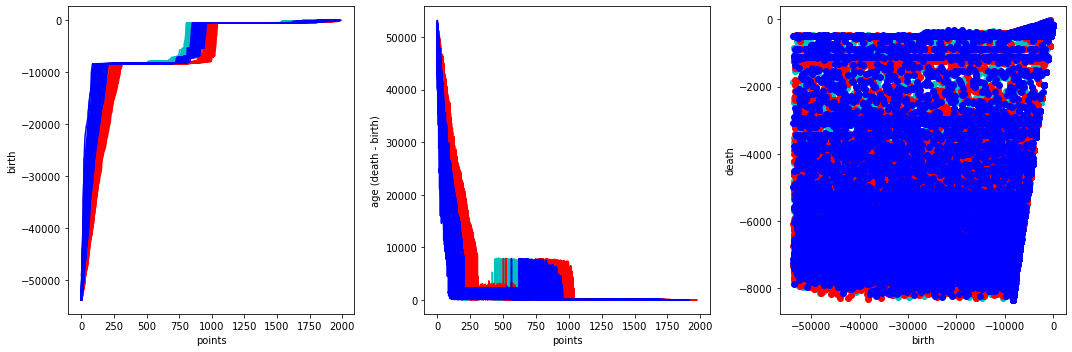

In [33]:
# visualize embeddings
import matplotlib as mpl
import matplotlib.cm as cm

import seaborn as sns

cmap = cm.Blues_r

colors = {0: "b",
          0.1: "c",
          0.2: "m",
          0.3: "r"}
_, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize=(15, 5))
for eps in embeddings:
    if not eps in [0., 0.1, 0.3]: continue
    color = colors[eps]
    for x in embeddings[eps]:
        birth, death = np.transpose(x)
        age = death - birth
        ax1.plot(birth, c=color)
        ax1.set_ylabel("birth")
        ax1.set_xlabel("points")
        # ax2.plot(death, c=color)
        # ax2.set_ylabel("death")
        # ax2.set_xlabel("points")
        ax3.plot(age, c=color)
        ax3.set_ylabel("age (death - birth)")
        ax3.set_xlabel("points")
        ax4.scatter(birth, death, c=color);
        ax4.set_xlabel("birth")
        ax4.set_ylabel("death")
plt.tight_layout()

In [36]:
# Plot performance of the detector
import pandas as pd
import seaborn as sns

df = []
for key in ["supervised_metrics", "unsupervised_metrics"]:
    tmp = evaluation_results[key]
    if key == "unsupervised_metrics":
        sup = False
    else:
        sup = True
    for eps in tmp:
        df.append(dict(sup=sup, eps=eps, auc=tmp[eps]["auc"]["upper_bound"],
                       method="PersistentDiagram",
                       arch=lenet_arch.name))
df = pd.DataFrame(df)

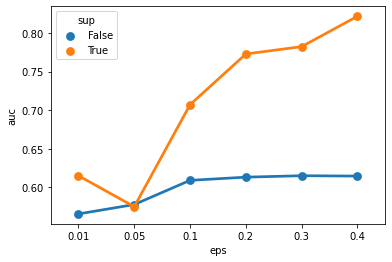

In [25]:
sns.pointplot(data=df, x="eps", y="auc", hue="sup");

In [ ]:
df

In [ ]:
layers

In [ ]:
lenet_arch.layers[-2].get_matrix()

In [ ]:
import scipy.sparse.linalg as slinalg

In [ ]:
mat = graph.get_adjacency_matrix()
mat

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(15, 8))
data = lenet_arch.layers[0].get_matrix()[-1].todense()[:2000].T
data = np.ma.masked_where(data == 0, data)
ax.matshow(data, cmap=plt.cm.RdBu);
ax.axis("off")

In [ ]:
graph._edge_dict.keys()

In [ ]:
lenet_arch.layers[4].get_matrix()

In [ ]:
from tda.graph import Graph

Graph.from_architecture_and_data_point(lenet_arch, X_train[0])

In [ ]:
graph._edge_dict

In [ ]:
from ripser.ripser import Rips

rips = Rips(maxdim=1)

In [ ]:
rips.fit_transform(graph.get_adjacency_matrix())

In [ ]:
graph.

In [ ]:
def get_edge_list(graph):
    """
    Generate the list of edges of the multipartite graph
    """
    shapes = graph._get_shapes()
    all_layer_indices = sorted(list(shapes.keys()))
    vertex_offset = [0] + list(np.cumsum([shapes[idx]
                                          for idx in all_layer_indices]))
    vertex_offset = vertex_offset[:-1]
    for source_layer, target_layer in graph._edge_dict:
        offset_source = vertex_offset[source_layer + 1]
        offset_target = vertex_offset[target_layer + 1]
        mat = graph._edge_dict[(source_layer, target_layer)]
        source_vertices = mat.col + offset_source
        target_vertices = mat.row + offset_target
        for edge, weight in zip(zip(source_vertices, target_vertices), mat.data):
            yield edge, weight

In [ ]:
timeit -n 1 graph.get_edge_list();

In [ ]:
timeit -n 1 list(get_edge_list(graph));

In [ ]:
del el

In [ ]:
8.08 / .777

In [ ]:
from tda.embeddings import persistent_diagrams
from tda import graph
from imp import reload

reload(persistent_diagrams)
reload(graph)
graph = graph.Graph.from_architecture_and_data_point(lenet_arch, X_train[0])


In [ ]:
toto = persistent_diagrams._prepare_edges_for_diagram_old(graph);
titi = persistent_diagrams._prepare_edges_for_diagram_fast(graph);

In [ ]:
titi = list(titi)

In [ ]:
titi[-1], toto[-1]

In [ ]:
for vertices, w in persistent_diagrams._prepare_edges_for_diagram_fast(graph):
    print(vertices, w)

In [ ]:
lenet_arch.layer_links

In [ ]:
import tda.embeddings.raw_graph as raw_graph

for layer_link in lenet_arch.layer_links[::-1]:
    active_indices = raw_graph.identify_active_indices([raw_graph.to_sparse_vector(
        line.graph._edge_dict[layer_link]) for line in train_clean])
    break

In [ ]:
line.graph._edge_dict[layer_link].shape

In [ ]:
a = train_clean[4].graph._edge_dict[layer_link].todense()
b = train_clean[11].graph._edge_dict[layer_link].todense()
c = train_adv[0.2][4].graph._edge_dict[layer_link].todense()
plt.matshow(a[:, :200])
plt.axis("off")
plt.matshow(b[:, :200])
plt.axis("off");
plt.matshow(c[:, :200])
plt.axis("off");

In [ ]:
from sklearn.random_projection import SparseRandomProjection

srp = SparseRandomProjection(random_state=0)

proj_mat = srp._make_random_matrix(100, 11520 * 784)

In [ ]:
plt.matshow(mean[:, :100])
plt.axis("off");

In [ ]:
plt.plot(proj_mat.dot(a.ravel().T))

In [ ]:
b[0]

In [ ]:
y_clean = np.array([line.y for line in train_clean])
graph_clean = [line.graph for line in train_clean]

In [ ]:
indices = np.where(y_clean == 6)[0].build_matrix()

In [ ]:
mean = np.mean([graph_clean[i]._edge_dict[layer_link].todense() for i in indices], axis=0)

In [ ]:
a = lenet_arch.layers[2].build_matrix(old=True).todense()
b = lenet_arch.layers[2].build_matrix(old=False).todense()

import numpy as np
a - b

In [ ]:
timeit lenet_arch.layers[2].build_matrix(old=False)

In [ ]:
timeit lenet_arch.layers[2].build_matrix(old=True)

In [6]:
import sys
sys.path.append("../universal-attacks/")

from imp import reload
import torch
import universal_attacks.models as models
reload(models)

# load pretrained model and prepare dataset fetcher
model, ds_fetcher, class_names = models.get_cifar100(
    model_root="pytorch_data")
class_indices = dict(zip(class_names.values(), class_names.keys()))

# turn off dropout
model.eval()

# fetch data
for X_train, y_train in ds_fetcher(batch_size=1000, train=True, val=False):
    break
for X_test, y_test in ds_fetcher(batch_size=50000, train=False, val=True):
    break
    
# save mem
if False:
  model = model.float()
  X_train = X_train.float()
  y_train = y_train.float()
  X_test = X_test.float()
  y_test = y_test.float()

# transfer data to GPU
if torch.cuda.is_available():
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

Building and initializing cifar100 parameters
Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padd

Building CIFAR-100 data loader with 1 workers
Files already downloaded and verified
Building CIFAR-100 data loader with 1 workers
Files already downloaded and verified


In [7]:
reload(parser)
arch = parser.model_to_architecture(model, x=X_train[0])

2020-05-17 08:55:18,670 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7f778f53ecd0> received input with shape torch.Size([1, 3, 32, 32])
<tda.models.layers.conv_layer.ConvLayer object at 0x7f778f53ecd0> received input with shape torch.Size([1, 3, 32, 32])
2020-05-17 08:55:18,673 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7f778e8e9cd0> received input with shape torch.Size([1, 128, 32, 32])
<tda.models.layers.conv_layer.ConvLayer object at 0x7f778e8e9cd0> received input with shape torch.Size([1, 128, 32, 32])
2020-05-17 08:55:18,688 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7f778e8e92d0> received input with shape torch.Size([1, 128, 16, 16])
<tda.models.layers.conv_layer.ConvLayer object at 0x7f778e8e92d0> received input with shape torch.Size([1, 128, 16, 16])
2020-05-17 08:55:18,694 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7f778e8e95d0> received input with shape torch.

In [ ]:
from tda.graph import Graph

graph = Graph.from_architecture_and_data_point(arch, X_train[0])
for key in graph._edge_dict:
    layer_matrix = graph._edge_dict[key]
    print(layer_matrix.shape)

In [ ]:
for c in lenet.named_children():
    print(c)

In [ ]:
def _unroll(model):
    for child in model.children():
        if len(list(child.children())):
            for grandchild in _unroll(child):
                yield grandchild
        else:
            yield child

for c in _unroll(model.features):
    print(c)

In [ ]:
def lprint(a):
    if isinstance(a, list):
        for i in a:
            yield from lprint(i)
    else:
        yield a

a = [[1, [2, 3], 4], [5, 6, [7, 8, [9]]]]
for i in lprint(b):
    print(i)

In [ ]:
model.n